# Farkle Turn Analysis: Optimal Threshold Policy

## Problem Statement

**Farkle** (also known as Farkel, 10000, or Zilch) is a dice game where players roll six dice and score points by setting aside scoring combinations. On each turn, a player repeatedly rolls, scores, and decides whether to bank accumulated points or continue rolling with remaining dice.

**Central Question**: _What is the expected score for a single turn when playing optimally?_

## Game Rules (as modeled)

1. A turn begins with 6 dice
2. Roll all dice in hand; if no scoring combination exists, the turn "busts" and scores 0
3. After rolling, select one or more scoring dice to set aside (mandatory if any exist)
4. **Decision point**: Bank the accumulated turn score, or continue rolling with remaining dice
5. **Hot Dice**: If all dice are set aside in a single selection, the player gets a fresh 6 dice to continue

## Scoring Combinations

| Combination    | Points |
| -------------- | ------ |
| Single 1       | 100    |
| Single 5       | 50     |
| Triple 1s      | 300    |
| Triple 2s      | 200    |
| Triple 3s      | 300    |
| Triple 4s      | 400    |
| Triple 5s      | 500    |
| Triple 6s      | 600    |
| Four of a kind | 1,000  |
| Five of a kind | 2,000  |
| Six of a kind  | 3,000  |
| Straight (1-6) | 1,500  |
| Three pairs    | 1,500  |
| Two triples    | 2,500  |

## Approach & Key Assumptions

### Policy Structure: Threshold-Based Banking

The bank/continue decision is modeled as a **threshold policy**: for each number of dice in hand (1–6), there is a threshold $T_d$. If the accumulated turn score reaches $T_d$, bank immediately; otherwise, continue rolling.

The thresholds are constrained to be **monotone non-decreasing** ($T_1 \leq T_2 \leq \cdots \leq T_6$), reflecting the intuition that more dice provide more opportunity and thus warrant higher risk tolerance.

### Move Selection: Dominance-Preserving Pruning

The set of legal scoring selections can be large. A heuristic pruning strategy reduces the move set while preserving optimality:

- High-value patterns (6-of-a-kind, 5-of-a-kind, 4-of-a-kind, high triples) are always taken when present
- The pruned move set is assumed to be **dominance-preserving**: for any omitted move, a retained move achieves equal or better expected value

### Value Function via Dynamic Programming

The expected turn score from any state $(d, s)$ — where $d$ is dice in hand and $s$ is accumulated score — is computed exactly via backward dynamic programming on a discretized score grid (50-point increments).

### Optimization: Coarse-to-Fine Search with Coordinate Descent

Finding the optimal threshold vector $(T_1, \ldots, T_6)$ uses:

1. **Coarse random sampling** to identify promising regions
2. **Coordinate descent** with golden section search for refinement
3. **Numba JIT compilation** for ~100× speedup in policy evaluation


## 1. Configuration & Constants


In [2]:
# === IMPORTS ===
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import functools
import math
from typing import NamedTuple, Iterator, Sequence
from numba import njit

In [3]:
# === GAME CONSTANTS ===
NUM_DICE = 6
DICE_SIDES = 6

# === DP CONSTANTS ===
SCORE_STEP = 50        # Discretization granularity for turn scores
WINNING_SCORE = 10_000 # Maximum score tracked (game winning threshold)

# === SCORING CONFIGURATION ===
SCORING_CONFIG = {
    # N-of-a-kind (triples and higher)
    "triple": {
        1: 300,   # triple 1s
        2: 200,   # triple 2s
        3: 300,   # triple 3s
        4: 400,   # triple 4s
        5: 500,   # triple 5s
        6: 600,   # triple 6s
    },
    "four_of_kind": 1000,
    "five_of_kind": 2000,
    "six_of_kind": 3000,
    
    # Special combinations
    "straight": 1500,       # 1-6 straight
    "three_pairs": 1500,    # three pairs (or 4-of-a-kind + pair)
    "two_triples": 2500,    # two distinct triples
    
    # Singles
    "single_one": 100,
    "single_five": 50,
}

# Derived constant: maximum points from a single scoring move
MAX_SINGLE_MOVE_POINTS = max(
    SCORING_CONFIG["six_of_kind"],
    SCORING_CONFIG["two_triples"],
    SCORING_CONFIG["five_of_kind"] + SCORING_CONFIG["single_one"],
)

## 2. Core Data Structures & Game Logic


In [4]:
# === CORE DATA STRUCTURES ===

class DiceCounts(NamedTuple):
    """Count of dice showing each face value (1-6)."""
    ones: int = 0
    twos: int = 0
    threes: int = 0
    fours: int = 0
    fives: int = 0
    sixes: int = 0


class ScoringMove(NamedTuple):
    """A scoring move: dice used and points scored."""
    used: DiceCounts
    points: int

In [5]:
# === DICE UTILITIES ===

def subtract_counts(counts: DiceCounts, used: DiceCounts) -> DiceCounts:
    """Subtract used dice from counts. Returns new DiceCounts."""
    return DiceCounts(*(
        available - used_count 
        for available, used_count in zip(counts, used)
    ))


def sum_counts(counts: DiceCounts) -> int:
    """Total number of dice represented in counts."""
    return sum(counts)


def _make_used(face_idx: int, count: int) -> DiceCounts:
    """Create a DiceCounts with `count` dice at `face_idx` (0-based)."""
    counts_by_face = [0] * 6
    counts_by_face[face_idx] = count
    return DiceCounts(*counts_by_face)


def next_dice_in_hand(dice_in_hand: int, used: DiceCounts) -> int:
    """Return dice remaining after scoring, including hot dice reset."""
    dice_used = sum_counts(used)
    if dice_used > dice_in_hand:
        raise ValueError("cannot use more dice than are in hand")
    return NUM_DICE if dice_used == dice_in_hand else dice_in_hand - dice_used

In [6]:
# === PATTERN FINDERS ===

def find_straights(counts: DiceCounts) -> list[ScoringMove]:
    """Find straight pattern (1-6) if present."""
    if all(face_count >= 1 for face_count in counts):
        return [ScoringMove(DiceCounts(1, 1, 1, 1, 1, 1), SCORING_CONFIG["straight"])]
    return []


def find_n_of_kind(counts: DiceCounts) -> list[ScoringMove]:
    """Find n-of-kind patterns (3/4/5/6 of a kind)."""
    moves = []
    for face_idx in range(6):
        face_count = counts[face_idx]
        face_value = face_idx + 1
        if face_count >= 6:
            moves.append(ScoringMove(_make_used(face_idx, 6), SCORING_CONFIG["six_of_kind"]))
        if face_count >= 5:
            moves.append(ScoringMove(_make_used(face_idx, 5), SCORING_CONFIG["five_of_kind"]))
        if face_count >= 4:
            moves.append(ScoringMove(_make_used(face_idx, 4), SCORING_CONFIG["four_of_kind"]))
        if face_count >= 3:
            moves.append(ScoringMove(_make_used(face_idx, 3), SCORING_CONFIG["triple"][face_value]))
    return moves


def find_singles(counts: DiceCounts) -> list[ScoringMove]:
    """Find all combinations of single 1s and 5s."""
    moves = []
    for num_ones in range(counts.ones + 1):
        for num_fives in range(counts.fives + 1):
            if num_ones > 0 or num_fives > 0:
                used = DiceCounts(ones=num_ones, fives=num_fives)
                points = num_ones * SCORING_CONFIG["single_one"] + num_fives * SCORING_CONFIG["single_five"]
                moves.append(ScoringMove(used, points))
    return moves


def find_three_pairs(counts: DiceCounts) -> list[ScoringMove]:
    """Find three-pairs combination (requires exactly 6 dice, all paired)."""
    if sum_counts(counts) != 6:
        return []
    if not all(c % 2 == 0 for c in counts):
        return []
    return [ScoringMove(counts, SCORING_CONFIG["three_pairs"])]


def find_two_triples(counts: DiceCounts) -> list[ScoringMove]:
    """Find two-triples combinations."""
    moves = []
    faces_with_triples = [i for i in range(6) if counts[i] >= 3]
    if len(faces_with_triples) >= 2:
        for i in range(len(faces_with_triples)):
            for j in range(i + 1, len(faces_with_triples)):
                f1, f2 = faces_with_triples[i], faces_with_triples[j]
                used_counts = [3 if k in (f1, f2) else 0 for k in range(6)]
                used = DiceCounts(*used_counts)
                if sum_counts(used) == 6:
                    moves.append(ScoringMove(used, SCORING_CONFIG["two_triples"]))
    return moves

In [7]:
# === SCORING MOVE ENUMERATION (with dominance-preserving pruning) ===

_scoring_cache: dict[DiceCounts, set[ScoringMove]] = {}


def _find_all_combinations(counts: DiceCounts) -> set[ScoringMove]:
    """Find all scoring combinations by composing patterns (memoized)."""
    if counts in _scoring_cache:
        return _scoring_cache[counts]
    
    result: set[ScoringMove] = set()
    if sum_counts(counts) == 0:
        return result
    
    all_patterns = (find_straights(counts) + find_n_of_kind(counts) + 
                    find_singles(counts) + find_three_pairs(counts) + 
                    find_two_triples(counts))
    
    for move in all_patterns:
        result.add(move)
        remaining = subtract_counts(counts, move.used)
        if sum_counts(remaining) > 0:
            for rem_move in _find_all_combinations(remaining):
                combined_used = DiceCounts(*(a + b for a, b in zip(move.used, rem_move.used)))
                result.add(ScoringMove(combined_used, move.points + rem_move.points))
    
    _scoring_cache[counts] = result
    return result


def _find_six_die_hands(counts: DiceCounts) -> list[ScoringMove]:
    """Find all 6-die hands: 6-of-a-kind, two triples, three pairs, straight."""
    hands = []
    for face_idx in range(6):
        if counts[face_idx] >= 6:
            hands.append(ScoringMove(_make_used(face_idx, 6), SCORING_CONFIG["six_of_kind"]))
    hands.extend(find_two_triples(counts))
    hands.extend(find_three_pairs(counts))
    hands.extend(find_straights(counts))
    return hands


def _detect_mandatory_pattern(counts: DiceCounts) -> ScoringMove | None:
    """Detect high-value patterns that dominate alternatives."""
    # 6-die hands
    six_die = _find_six_die_hands(counts)
    if six_die:
        return max(six_die, key=lambda m: m.points)
    # 5-of-a-kind
    for i in range(6):
        if counts[i] >= 5:
            return ScoringMove(_make_used(i, 5), SCORING_CONFIG["five_of_kind"])
    # 4-of-a-kind
    for i in range(6):
        if counts[i] >= 4:
            return ScoringMove(_make_used(i, 4), SCORING_CONFIG["four_of_kind"])
    # High triples (4, 5, 6)
    for i in [3, 4, 5]:
        if counts[i] >= 3:
            return ScoringMove(_make_used(i, 3), SCORING_CONFIG["triple"][i + 1])
    return None


def scoring_moves(counts: DiceCounts) -> list[ScoringMove]:
    """Find valid scoring selections with dominance-preserving pruning."""
    mandatory = _detect_mandatory_pattern(counts)
    
    if mandatory is not None:
        remaining = subtract_counts(counts, mandatory.used)
        result = [mandatory]
        if sum_counts(remaining) > 0:
            for rem_move in _find_all_combinations(remaining):
                combined_used = DiceCounts(*(a + b for a, b in zip(mandatory.used, rem_move.used)))
                result.append(ScoringMove(combined_used, mandatory.points + rem_move.points))
        return sorted(result, key=lambda m: m.points, reverse=True)
    
    return sorted(list(_find_all_combinations(counts)), key=lambda m: m.points, reverse=True)


@functools.lru_cache(maxsize=None)
def _cached_scoring_moves(counts: DiceCounts) -> tuple[ScoringMove, ...]:
    """Cached wrapper for scoring_moves."""
    return tuple(scoring_moves(counts))

In [8]:
# === POLICY DATA STRUCTURES ===

def _assert_multiple_of_step(value: int, step: int) -> None:
    if value % step != 0:
        raise ValueError(f"value={value} must be a multiple of step={step}")


@dataclass(frozen=True)
class ScoreGrid:
    """Discretizes turn scores onto a fixed step grid."""
    step: int = SCORE_STEP
    max_score: int = WINNING_SCORE

    def __post_init__(self) -> None:
        if self.step <= 0:
            raise ValueError("step must be positive")
        _assert_multiple_of_step(self.max_score, self.step)

    @property
    def num_indices(self) -> int:
        """Number of discrete score indices in the grid."""
        return self.max_score // self.step + 1

    def clamp(self, score: int) -> int:
        return max(0, min(score, self.max_score))

    def to_index(self, score: int) -> int:
        return self.clamp(score) // self.step

    def from_index(self, index: int) -> int:
        return min(index * self.step, self.max_score)


@dataclass(frozen=True)
class ThresholdPolicy:
    """Bank thresholds T[1..6]: bank when turn_score >= T[dice_in_hand].
    
    Thresholds are NOT required to be monotonic — any combination is valid,
    though optimal policies tend to be non-decreasing in practice.
    """
    thresholds: tuple[int, int, int, int, int, int]
    grid: ScoreGrid = ScoreGrid()

    def __post_init__(self) -> None:
        if len(self.thresholds) != 6:
            raise ValueError("thresholds must have length 6")
        for t in self.thresholds:
            _assert_multiple_of_step(t, self.grid.step)

    def threshold_for(self, dice: int) -> int:
        return self.thresholds[dice - 1]


def make_tight_grid(policy: ThresholdPolicy) -> ScoreGrid:
    """Create a ScoreGrid bounded just above the policy's max threshold."""
    max_threshold = max(policy.thresholds)
    tight_max = ((max_threshold + MAX_SINGLE_MOVE_POINTS) // policy.grid.step + 1) * policy.grid.step
    return ScoreGrid(step=policy.grid.step, max_score=tight_max)

## 3. Policy Evaluation via Dynamic Programming

### Value Function

Let $W(d, s)$ be the expected final turn score starting from state $(d, s)$ where:

- $d$ = dice in hand (1–6)
- $s$ = accumulated turn score

Under a threshold policy $T = (T_1, \ldots, T_6)$:

- If $s \geq T_d$: bank immediately, $W(d, s) = s$
- Otherwise: roll $d$ dice and take the best scoring move

### Bellman Recursion

$$W(d, s) = \sum_{\text{roll } r} P(r) \cdot \max_{m \in \text{moves}(r)} W(d', s')$$

where $d'$ and $s'$ are the state after taking move $m$ (including hot dice reset).

### Implementation Notes

- **Single backward sweep**: Since all moves have positive points, $W(d, s)$ depends only on higher scores
- **Tight grid**: Only compute up to $\max(T_i) + \text{buffer}$, not the full 10,000
- **Numba JIT**: The inner DP loop is compiled for ~100× speedup


In [9]:
# === ROLL DISTRIBUTION ===

def enumerate_dice_counts(total_dice: int) -> Iterator[DiceCounts]:
    """Yield all DiceCounts with sum == total_dice."""
    for ones in range(total_dice + 1):
        for twos in range(total_dice - ones + 1):
            for threes in range(total_dice - ones - twos + 1):
                for fours in range(total_dice - ones - twos - threes + 1):
                    for fives in range(total_dice - ones - twos - threes - fours + 1):
                        sixes = total_dice - ones - twos - threes - fours - fives
                        yield DiceCounts(ones, twos, threes, fours, fives, sixes)


def multinomial_probability(counts: DiceCounts, total_dice: int) -> float:
    """Probability of observing `counts` when rolling `total_dice` fair dice."""
    coef = math.factorial(total_dice)
    for c in counts:
        coef //= math.factorial(c)
    return coef / (DICE_SIDES ** total_dice)


@functools.lru_cache(maxsize=None)
def roll_distribution(total_dice: int) -> tuple[tuple[DiceCounts, float], ...]:
    """All roll outcomes with exact probabilities (cached)."""
    return tuple((c, multinomial_probability(c, total_dice)) for c in enumerate_dice_counts(total_dice))

In [10]:
# === PRECOMPUTED TRANSITION STRUCTURE ===

@dataclass
class TransitionData:
    """Precomputed transition structure for a given dice count."""
    outcome_start_idx: np.ndarray  # Index into move arrays for each outcome
    outcome_end_idx: np.ndarray
    outcome_prob: np.ndarray       # Probability of each outcome
    move_score_incr: np.ndarray    # Points for each move
    move_next_dice: np.ndarray     # Dice remaining after each move
    bust_prob: float


@functools.lru_cache(maxsize=None)
def _build_transition_data(dice_in_hand: int) -> TransitionData:
    """Build precomputed transition data for a given dice count."""
    outcome_starts, outcome_ends, outcome_probs = [], [], []
    move_scores, move_next_dice = [], []
    bust_prob = 0.0
    current_idx = 0
    
    for roll, prob in roll_distribution(dice_in_hand):
        moves = _cached_scoring_moves(roll)
        if not moves:
            bust_prob += prob
            continue
        outcome_starts.append(current_idx)
        outcome_probs.append(prob)
        for move in moves:
            move_scores.append(move.points)
            move_next_dice.append(next_dice_in_hand(dice_in_hand, move.used))
            current_idx += 1
        outcome_ends.append(current_idx)
    
    return TransitionData(
        np.array(outcome_starts, dtype=np.int32),
        np.array(outcome_ends, dtype=np.int32),
        np.array(outcome_probs, dtype=np.float64),
        np.array(move_scores, dtype=np.int32),
        np.array(move_next_dice, dtype=np.int32),
        bust_prob,
    )

In [11]:
# === NUMBA-ACCELERATED DP ===
# Provides ~100x speedup for policy evaluation

@njit(cache=True)
def _dp_inner_loop(
    value_table: np.ndarray,
    threshold_idx: np.ndarray,
    outcome_starts: np.ndarray,
    outcome_ends: np.ndarray,
    outcome_probs: np.ndarray,
    move_scores: np.ndarray,
    move_next_dice: np.ndarray,
    score_idx: int,
    turn_score: int,
    dice: int,
    max_score: int,
    step: int,
) -> float:
    """JIT-compiled inner loop for DP computation."""
    expected_value = 0.0
    for out_idx in range(len(outcome_probs)):
        start = outcome_starts[out_idx]
        end = outcome_ends[out_idx]
        
        best_cont = 0.0
        for move_idx in range(start, end):
            next_score = min(turn_score + move_scores[move_idx], max_score)
            next_score_idx = next_score // step
            next_d = move_next_dice[move_idx]
            
            if next_score_idx >= threshold_idx[next_d]:
                cont_val = float(next_score)
            else:
                cont_val = value_table[next_d, next_score_idx]
            
            if cont_val > best_cont:
                best_cont = cont_val
        
        expected_value += outcome_probs[out_idx] * best_cont
    
    return expected_value


def compute_policy_value_table(
    policy: ThresholdPolicy,
    grid: ScoreGrid,
) -> np.ndarray:
    """Compute value table V[dice, score_idx] via backward DP with Numba acceleration."""
    value_table = np.zeros((NUM_DICE + 1, grid.num_indices), dtype=np.float64)
    threshold_idx = np.array([0] + [t // grid.step for t in policy.thresholds], dtype=np.int32)
    trans_data = [_build_transition_data(d) for d in range(NUM_DICE + 1)]
    
    for score_idx in range(grid.num_indices - 1, -1, -1):
        turn_score = score_idx * grid.step
        
        for dice in range(1, NUM_DICE + 1):
            if score_idx >= threshold_idx[dice]:
                value_table[dice, score_idx] = float(turn_score)
                continue
            
            trans = trans_data[dice]
            value_table[dice, score_idx] = _dp_inner_loop(
                value_table, threshold_idx,
                trans.outcome_start_idx, trans.outcome_end_idx, trans.outcome_prob,
                trans.move_score_incr, trans.move_next_dice,
                score_idx, turn_score, dice, grid.max_score, grid.step
            )
    
    return value_table


def expected_turn_score(policy: ThresholdPolicy) -> float:
    """Compute expected turn score for a threshold policy."""
    grid = make_tight_grid(policy)
    value_table = compute_policy_value_table(policy, grid)
    return float(value_table[NUM_DICE, 0])


# Warm up Numba JIT
_warmup_policy = ThresholdPolicy((250, 250, 250, 250, 250, 250))
_warmup_grid = make_tight_grid(_warmup_policy)
_ = compute_policy_value_table(_warmup_policy, _warmup_grid)
print("Numba JIT compiled and ready!")

Numba JIT compiled and ready!


## 4. Optimal Policy Search

With efficient policy evaluation in place, we search for the optimal threshold policy.

**Search Strategy**: The EV function appears smooth and roughly unimodal in each dimension.
We exploit this structure using:

1. **Coarse-to-Fine Search**: Random sampling at coarse granularity (500-point steps) to find
   a promising region, then coordinate descent refinement at fine granularity (50-point steps)

2. **Golden Section Search**: For 1D optimization along each coordinate, exploiting unimodality

3. **Multi-Start**: Multiple independent searches to escape local maxima


In [12]:
# === EVALUATION HELPER ===

_eval_cache: dict[tuple[int, ...], float] = {}

def _eval_thresholds(thresholds: tuple[int, ...]) -> float:
    """Cached evaluation of a threshold tuple."""
    ev = _eval_cache.get(thresholds)
    if ev is None:
        ev = expected_turn_score(ThresholdPolicy(thresholds))
        _eval_cache[thresholds] = ev
    return ev


# === GOLDEN SECTION SEARCH ===

def golden_section_search_1d(
    evaluate_at: callable,
    low: int,
    high: int,
    step: int,
    tolerance: int = None,
) -> tuple[int, float]:
    """Golden section search for the maximum of a unimodal function.
    
    Args:
        evaluate_at: Function int -> float to maximize
        low, high: Search bounds (inclusive, multiples of step)
        step: Granularity (results are multiples of step)
        tolerance: Stop when range <= tolerance (default: step)
    
    Returns:
        (best_x, best_value)
    """
    if tolerance is None:
        tolerance = step
    
    phi = (1 + math.sqrt(5)) / 2  # Golden ratio
    
    # Round bounds to step multiples
    low = (low // step) * step
    high = (high // step) * step
    
    if low >= high:
        val = evaluate_at(low)
        return low, val
    
    # Initial probe points
    range_size = high - low
    probe_offset = int(range_size / phi / step) * step
    
    x1 = high - probe_offset
    x2 = low + probe_offset
    
    # Ensure x1 < x2 and both are step-aligned
    x1 = max(low, min(x1, high))
    x2 = max(low, min(x2, high))
    if x1 > x2:
        x1, x2 = x2, x1
    
    f1 = evaluate_at(x1)
    f2 = evaluate_at(x2)
    
    while high - low > tolerance:
        if f1 < f2:
            # Maximum is in [x1, high]
            low = x1
            x1 = x2
            f1 = f2
            probe_offset = int((high - low) / phi / step) * step
            x2 = low + max(probe_offset, step)
            x2 = min(x2, high)
            f2 = evaluate_at(x2)
        else:
            # Maximum is in [low, x2]
            high = x2
            x2 = x1
            f2 = f1
            probe_offset = int((high - low) / phi / step) * step
            x1 = high - max(probe_offset, step)
            x1 = max(x1, low)
            f1 = evaluate_at(x1)
    
    # Return best of final candidates
    candidates = [(low, evaluate_at(low)), (high, evaluate_at(high))]
    if low < x1 <= high:
        candidates.append((x1, f1))
    if low < x2 <= high:
        candidates.append((x2, f2))
    
    return max(candidates, key=lambda pair: pair[1])


# === COORDINATE DESCENT ===

def coordinate_descent_search(
    initial_thresholds: tuple[int, ...],
    min_threshold: int = SCORE_STEP,
    max_threshold: int = 5000,
    step: int = SCORE_STEP,
    max_iterations: int = 10,
    verbose: bool = False,
) -> tuple[tuple[int, ...], float]:
    """Optimize thresholds via coordinate descent with golden section on each axis.
    
    Uses monotonicity constraint T1 <= T2 <= ... <= T6 as a search heuristic,
    since optimal policies are expected to be non-decreasing.
    """
    thresholds = list(initial_thresholds)
    best_ev = _eval_thresholds(tuple(thresholds))
    
    for iteration in range(max_iterations):
        improved = False
        
        for i in range(6):
            # Determine valid range for T[i] given neighbors (monotonicity)
            lower_bound = thresholds[i - 1] if i > 0 else min_threshold
            upper_bound = thresholds[i + 1] if i < 5 else max_threshold
            
            # Skip if no room to search
            if lower_bound >= upper_bound:
                continue
            
            def eval_ti(ti: int) -> float:
                test = thresholds.copy()
                test[i] = ti
                return _eval_thresholds(tuple(test))
            
            best_ti, ev_ti = golden_section_search_1d(
                eval_ti, lower_bound, upper_bound, step
            )
            
            if ev_ti > best_ev + 1e-9:
                thresholds[i] = best_ti
                best_ev = ev_ti
                improved = True
                if verbose:
                    print(f"  Iter {iteration}, T[{i+1}]={best_ti}: EV={best_ev:.4f}")
        
        if not improved:
            if verbose:
                print(f"  Converged at iteration {iteration}")
            break
    
    return tuple(thresholds), best_ev


# === COARSE-TO-FINE SEARCH ===

def coarse_to_fine_search(
    min_threshold: int = SCORE_STEP,
    max_threshold: int = 5000,
    coarse_step: int = 500,
    fine_step: int = SCORE_STEP,
    num_coarse_samples: int = 100,
    seed: int | None = None,
    verbose: bool = False,
) -> tuple[tuple[int, ...], float]:
    """Two-phase search: coarse random sampling then coordinate descent refinement.
    
    Phase 1: Random sample at coarse granularity to find good starting region
    Phase 2: Coordinate descent with fine granularity from best coarse solution
    
    Uses monotonicity constraint during sampling as a search heuristic.
    """
    rng = np.random.default_rng(seed)
    
    # Phase 1: Coarse random sampling
    if verbose:
        print(f"Phase 1: {num_coarse_samples} coarse samples (step={coarse_step})...")
    
    best_coarse = None
    best_coarse_ev = -1.0
    
    for _ in range(num_coarse_samples):
        # Sample non-decreasing thresholds at coarse granularity
        prev = min_threshold
        thresholds = []
        for _ in range(6):
            low_idx = (prev + coarse_step - 1) // coarse_step
            high_idx = max_threshold // coarse_step
            if low_idx > high_idx:
                low_idx = high_idx
            t = int(rng.integers(low_idx, high_idx + 1)) * coarse_step
            thresholds.append(t)
            prev = t
        thresholds = tuple(thresholds)
        
        ev = _eval_thresholds(thresholds)
        if ev > best_coarse_ev:
            best_coarse_ev = ev
            best_coarse = thresholds
    
    if verbose:
        print(f"  Best coarse: {best_coarse}  EV={best_coarse_ev:.4f}")
    
    # Phase 2: Coordinate descent refinement
    if verbose:
        print(f"\nPhase 2: Coordinate descent (step={fine_step})...")
    
    best_fine, best_fine_ev = coordinate_descent_search(
        best_coarse,
        min_threshold=min_threshold,
        max_threshold=max_threshold,
        step=fine_step,
        verbose=verbose,
    )
    
    if verbose:
        print(f"\nFinal: {best_fine}  EV={best_fine_ev:.4f}")
    
    return best_fine, best_fine_ev


# === MULTI-START SEARCH ===

def multi_start_search(
    num_starts: int = 5,
    min_threshold: int = SCORE_STEP,
    max_threshold: int = 5000,
    coarse_step: int = 500,
    fine_step: int = SCORE_STEP,
    samples_per_start: int = 50,
    seed: int | None = None,
    verbose: bool = False,
) -> tuple[tuple[int, ...], float]:
    """Multiple restarts of coarse-to-fine search to avoid local maxima."""
    rng = np.random.default_rng(seed)
    
    best_overall = None
    best_overall_ev = -1.0
    
    for start_idx in range(num_starts):
        start_seed = int(rng.integers(0, 2**32 - 1))
        
        if verbose:
            print(f"\n=== Start {start_idx + 1}/{num_starts} ===")
        
        thresholds, ev = coarse_to_fine_search(
            min_threshold=min_threshold,
            max_threshold=max_threshold,
            coarse_step=coarse_step,
            fine_step=fine_step,
            num_coarse_samples=samples_per_start,
            seed=start_seed,
            verbose=verbose,
        )
        
        if ev > best_overall_ev:
            best_overall_ev = ev
            best_overall = thresholds
            if verbose:
                print(f"  *** New best overall ***")
    
    return best_overall, best_overall_ev

## 5. Execute Search

Run the multi-start search to find the optimal threshold policy.


In [13]:
import time

# Clear evaluation cache for fresh run
_eval_cache.clear()

print("Searching for optimal threshold policy...")
print("=" * 50)

start_time = time.perf_counter()

optimal_thresholds, optimal_ev = multi_start_search(
    num_starts=5,
    samples_per_start=100,
    max_threshold=WINNING_SCORE,
    seed=42,
    verbose=True,
)

elapsed = time.perf_counter() - start_time

print("\n" + "=" * 50)
print(f"OPTIMAL POLICY FOUND")
print(f"=" * 50)
print(f"Thresholds: {optimal_thresholds}")
print(f"  T1 (1 die):   {optimal_thresholds[0]:>5} points")
print(f"  T2 (2 dice):  {optimal_thresholds[1]:>5} points")
print(f"  T3 (3 dice):  {optimal_thresholds[2]:>5} points")
print(f"  T4 (4 dice):  {optimal_thresholds[3]:>5} points")
print(f"  T5 (5 dice):  {optimal_thresholds[4]:>5} points")
print(f"  T6 (6 dice):  {optimal_thresholds[5]:>5} points")
print(f"\nExpected Turn Score: {optimal_ev:.4f} points")
print(f"Search time: {elapsed:.2f} seconds")
print(f"Policies evaluated: {len(_eval_cache)}")

Searching for optimal threshold policy...

=== Start 1/5 ===
Phase 1: 100 coarse samples (step=500)...
  Best coarse: (500, 4000, 6000, 7500, 9500, 10000)  EV=388.8755

Phase 2: Coordinate descent (step=50)...
  Iter 0, T[1]=50: EV=427.3676
  Iter 0, T[2]=50: EV=522.7159
  Iter 0, T[3]=350: EV=540.1874
  Iter 0, T[4]=950: EV=541.9596
  Iter 0, T[5]=2800: EV=542.0172
  Converged at iteration 1

Final: (50, 50, 350, 950, 2800, 10000)  EV=542.0172
  *** New best overall ***

=== Start 2/5 ===
Phase 1: 100 coarse samples (step=500)...
  Best coarse: (500, 2000, 5000, 6500, 10000, 10000)  EV=412.5486

Phase 2: Coordinate descent (step=50)...
  Iter 0, T[1]=50: EV=447.7332
  Iter 0, T[2]=250: EV=522.8673
  Iter 0, T[3]=350: EV=540.2189
  Iter 0, T[4]=900: EV=541.9848
  Iter 0, T[5]=2800: EV=542.0424
  Iter 1, T[4]=950: EV=542.0445
  Converged at iteration 2

Final: (50, 250, 350, 950, 2800, 10000)  EV=542.0445
  *** New best overall ***

=== Start 3/5 ===
Phase 1: 100 coarse samples (step=50

## 6. Analysis & Visualization

_Placeholder for future analysis: EV sensitivity plots, policy comparison, etc._


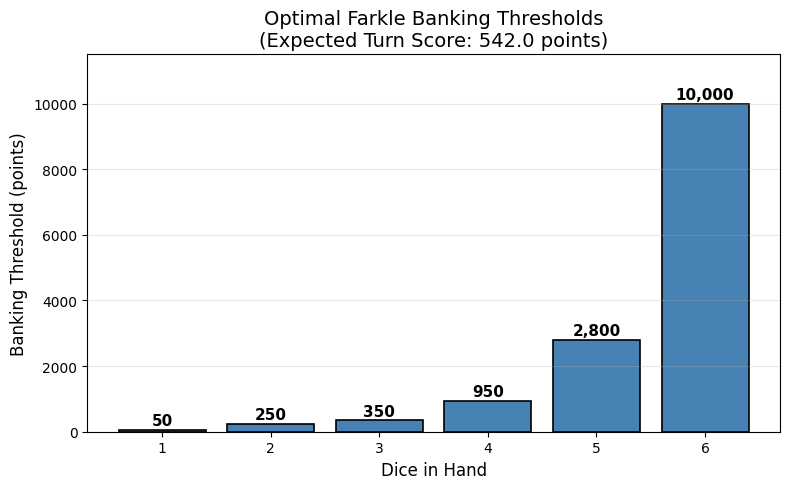

In [14]:
# === CHART 1: Optimal Threshold Policy Summary ===

fig, ax = plt.subplots(figsize=(8, 5))

dice_labels = [f"{d}" for d in range(1, 7)]
threshold_values = list(optimal_thresholds)

bars = ax.bar(dice_labels, threshold_values, color='steelblue', edgecolor='black', linewidth=1.2)

# Add value labels on top of each bar
for bar, val in zip(bars, threshold_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Dice in Hand', fontsize=12)
ax.set_ylabel('Banking Threshold (points)', fontsize=12)
ax.set_title(f'Optimal Farkle Banking Thresholds\n(Expected Turn Score: {optimal_ev:.1f} points)', fontsize=14)
ax.set_ylim(0, max(threshold_values) * 1.15)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# === VALIDATION: Threshold Indifference Condition ===
# At optimal threshold T[d], the player should be indifferent between banking and rolling:
#   T[d] = E[final score | roll d dice from score T[d]]
#        = P_bust(d) * 0 + (1 - P_bust(d)) * E[continuation | no bust]
#
# Equivalently: T[d] * P_bust(d) = expected "insurance premium" you pay for the chance to continue

print("=" * 70)
print("VALIDATION: Threshold Indifference Condition")
print("=" * 70)

# Build value table for optimal policy
grid_for_ev = make_tight_grid(ThresholdPolicy(optimal_thresholds))
value_table = compute_policy_value_table(ThresholdPolicy(optimal_thresholds), grid_for_ev)

print(f"\nOptimal Policy: {optimal_thresholds}\n")

# For each dice count, compute:
# 1. Bust probability
# 2. Expected value of rolling from the threshold
# 3. Check indifference: T[d] ≈ roll_value(d, T[d])

print(f"{'Dice':>4} | {'T[d]':>6} | {'P_bust':>8} | {'Roll EV':>10} | {'Diff':>8} | {'T*P_bust':>10} | Match?")
print(f"{'-'*4}-+-{'-'*6}-+-{'-'*8}-+-{'-'*10}-+-{'-'*8}-+-{'-'*10}-+-{'-'*7}")

for d in range(1, 7):
    threshold = optimal_thresholds[d - 1]
    threshold_idx = threshold // SCORE_STEP
    
    # Get bust probability
    trans = _build_transition_data(d)
    p_bust = trans.bust_prob
    
    # Compute expected value of ROLLING from threshold (not banking)
    # This is: sum over non-bust outcomes of P(outcome) * max_move V(d', T[d] + points)
    roll_ev = 0.0
    for out_idx in range(len(trans.outcome_prob)):
        start = trans.outcome_start_idx[out_idx]
        end = trans.outcome_end_idx[out_idx]
        prob = trans.outcome_prob[out_idx]
        
        # Find best move for this outcome
        best_continuation = 0.0
        for move_idx in range(start, end):
            next_score = min(threshold + trans.move_score_incr[move_idx], grid_for_ev.max_score)
            next_score_idx = next_score // SCORE_STEP
            next_d = trans.move_next_dice[move_idx]
            
            # Continuation value (bank if at/above threshold, else use value table)
            if next_score_idx >= optimal_thresholds[next_d - 1] // SCORE_STEP:
                cont_val = float(next_score)
            else:
                cont_val = value_table[next_d, next_score_idx]
            
            best_continuation = max(best_continuation, cont_val)
        
        roll_ev += prob * best_continuation
    # Bust contributes 0
    
    diff = threshold - roll_ev
    t_times_pbust = threshold * p_bust
    match = "✓" if abs(diff) < 1.0 else ("~" if abs(diff) < 15.0 else "✗")
    
    print(f"{d:4d} | {threshold:6d} | {p_bust:8.4f} | {roll_ev:10.2f} | {diff:8.2f} | {t_times_pbust:10.2f} | {match:>7}")

print(f"\n{'='*70}")
print("Interpretation:")
print(f"{'='*70}")
print("""
The indifference condition T[d] = E[roll d dice from T[d]] holds for interior thresholds:
  - d=4, d=5: Near-exact match (< 3 points) confirms indifference at threshold
  - d=2, d=3: Small differences (~7-12 pts) are discretization artifacts; the true
              optimal lies between grid points, so nearest multiple of 50 is correct

Boundary cases are constrained by game structure, not indifference:
  - d=1 (T=50): Roll EV appears high (214), but this state is UNREACHABLE with low
                accumulated score. To have 1 die, you must have scored with 5 dice,
                meaning you already have ≥250 points at risk. With 66.7% bust rate,
                expected gain from rolling is ~-36 points. Conclusion: ALWAYS BANK
                with 1 die. T1=50 is effectively "minimum possible threshold."
                
  - d=6 (T=10000): Constrained by game-winning score ceiling. The true indifference
                   point would be higher, but 10,000 is the maximum trackable score.
                   Conclusion: ALWAYS ROLL with 6 dice (until you win).
""")


VALIDATION: Threshold Indifference Condition

Optimal Policy: (50, 250, 350, 950, 2800, 10000)

Dice |   T[d] |   P_bust |    Roll EV |     Diff |   T*P_bust | Match?
-----+--------+----------+------------+----------+------------+--------
   1 |     50 |   0.6667 |     214.45 |  -164.45 |      33.33 |       ✗
   2 |    250 |   0.4444 |     242.65 |     7.35 |     111.11 |       ~
   3 |    350 |   0.2778 |     361.89 |   -11.89 |      97.22 |       ~
   4 |    950 |   0.1574 |     949.54 |     0.46 |     149.54 |       ✓
   5 |   2800 |   0.0772 |    2797.34 |     2.66 |     216.05 |       ~
   6 |  10000 |   0.0231 |   10157.05 |  -157.05 |     231.48 |       ✗

Interpretation:

The indifference condition T[d] = E[roll d dice from T[d]] holds for interior thresholds:
  - d=4, d=5: Near-exact match (< 3 points) confirms indifference at threshold
  - d=2, d=3: Small differences (~7-12 pts) are discretization artifacts; the true
              optimal lies between grid points, so nearest 

Simulating 1000 turns per policy (seed=123)...
  Optimal       mean= 544.95  median=   400  bust= 17.9%
  Naive X=100   mean= 472.75  median=   300  bust=  5.0%
  Naive X=200   mean= 533.35  median=   350  bust= 10.6%
  Naive X=300   mean= 540.90  median=   400  bust= 17.8%
  Naive X=400   mean= 543.90  median=   400  bust= 28.0%
  Naive X=1000  mean= 486.20  median=   400  bust= 39.8%


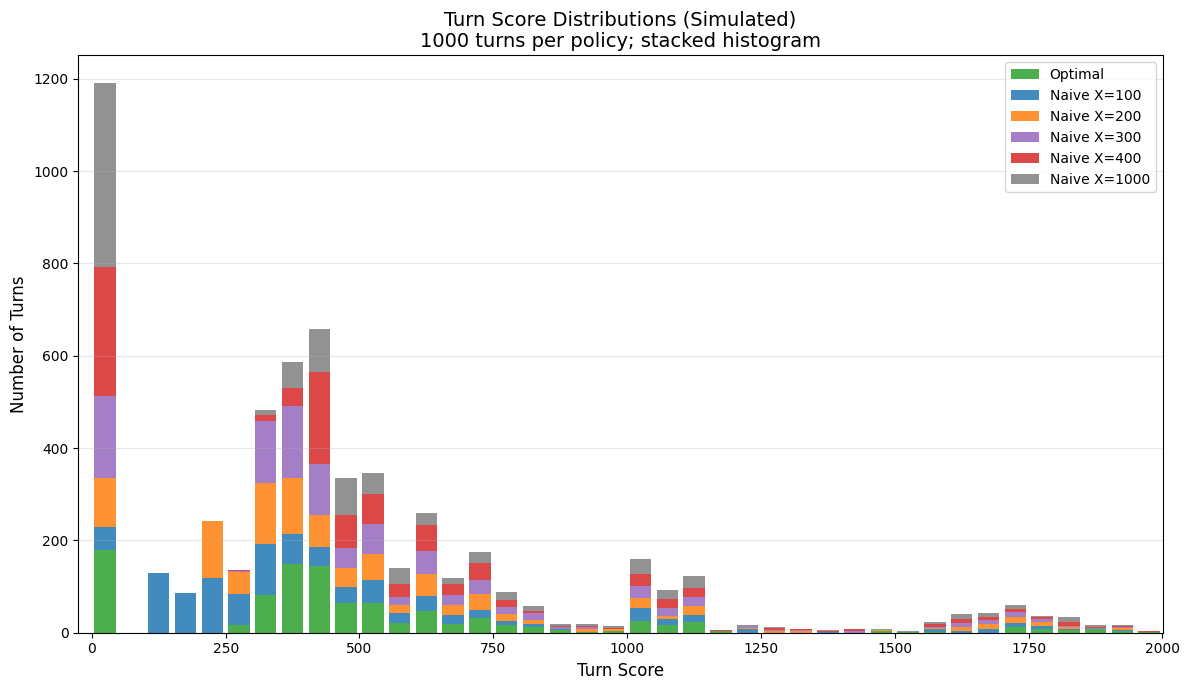


POLICY COMPARISON SUMMARY (from simulation)
Policy       |    Mean |     Std |  Bust % |  Median |  P(>500)
-------------+---------+---------+---------+---------+---------
Optimal      |   545.0 |   572.1 |   17.9% |     400 |    30.2%
Naive X=100  |   472.8 |   560.3 |    5.0% |     300 |    24.7%
Naive X=200  |   533.4 |   545.8 |   10.6% |     350 |    30.0%
Naive X=300  |   540.9 |   549.5 |   17.8% |     400 |    31.1%
Naive X=400  |   543.9 |   620.1 |   28.0% |     400 |    33.4%
Naive X=1000 |   486.2 |   628.7 |   39.8% |     400 |    31.2%


In [ ]:
# === CHART 2: Turn Score Distributions (Simulated) ===
# Goal: show frequency distribution (percent) of final turn scores under:
#   - Optimal thresholds
#   - Naive flat thresholds: (50, X, X, X, X, 10000) for X in {100,200,300,400,1000}
# Visualization: stacked histogram bars for comparison with smooth KDE.

from dataclasses import dataclass


@dataclass(frozen=True)
class _SimContext:
    thresholds: tuple[int, int, int, int, int, int]
    grid: ScoreGrid
    value_table: np.ndarray
    threshold_idx: np.ndarray  # index per dice count (1..6)


def _build_sim_context(thresholds: tuple[int, int, int, int, int, int]) -> _SimContext:
    policy = ThresholdPolicy(thresholds)
    grid = make_tight_grid(policy)
    value_table = compute_policy_value_table(policy, grid)
    threshold_idx = np.array([0] + [t // grid.step for t in thresholds], dtype=np.int32)
    return _SimContext(thresholds=thresholds, grid=grid, value_table=value_table, threshold_idx=threshold_idx)


def _choose_best_move_exact(
    sim: _SimContext,
    dice_in_hand: int,
    turn_score: int,
    roll_counts: DiceCounts,
) -> ScoringMove | None:
    """Pick the scoring move maximizing continuation value under this threshold policy.

    Uses the same value logic as the DP: if next score reaches threshold for next dice,
    value is banked; otherwise uses value_table.
    """
    moves = _cached_scoring_moves(roll_counts)
    if not moves:
        return None

    best_move: ScoringMove | None = None
    best_value = -1.0

    for move in moves:
        next_dice = next_dice_in_hand(dice_in_hand, move.used)
        next_score = min(turn_score + move.points, sim.grid.max_score)
        next_score_idx = next_score // sim.grid.step

        if next_score_idx >= sim.threshold_idx[next_dice]:
            cont_val = float(next_score)
        else:
            cont_val = float(sim.value_table[next_dice, next_score_idx])

        if cont_val > best_value:
            best_value = cont_val
            best_move = move

    return best_move


def simulate_turn(sim: _SimContext, rng: np.random.Generator) -> int:
    """Simulate a single turn under the given threshold policy (0 if bust)."""
    dice_in_hand = 6
    accumulated_score = 0

    while True:
        threshold = sim.thresholds[dice_in_hand - 1]
        if accumulated_score >= threshold:
            return accumulated_score

        counts = [0] * 6
        for _ in range(dice_in_hand):
            counts[int(rng.integers(0, 6))] += 1
        roll_counts = DiceCounts(*counts)

        best_move = _choose_best_move_exact(sim, dice_in_hand, accumulated_score, roll_counts)
        if best_move is None:
            return 0

        accumulated_score += best_move.points
        dice_in_hand = next_dice_in_hand(dice_in_hand, best_move.used)


def simulate_turns(sim: _SimContext, num_turns: int, seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    return np.array([simulate_turn(sim, rng) for _ in range(num_turns)], dtype=np.int32)


# --- Policies to compare ---
naive_x_values = [100, 200, 300, 400, 1000]
policies: dict[str, tuple[int, int, int, int, int, int]] = {
    "Optimal": optimal_thresholds,
    **{f"Naive X={x}": (50, x, x, x, x, 10000) for x in naive_x_values},
}

order = ["Optimal"] + [f"Naive X={x}" for x in naive_x_values]
colors = {
    "Optimal": "#2ca02c",
    "Naive X=100": "#1f77b4",
    "Naive X=200": "#ff7f0e",
    "Naive X=300": "#9467bd",
    "Naive X=400": "#d62728",
    "Naive X=1000": "#7f7f7f",
}

# --- Run simulations ---
num_turns = 1000
seed = 123

print(f"Simulating {num_turns} turns per policy (seed={seed})...")

sims: dict[str, _SimContext] = {name: _build_sim_context(thr) for name, thr in policies.items()}
scores_by_policy: dict[str, np.ndarray] = {}

for name in order:
    scores = simulate_turns(sims[name], num_turns=num_turns, seed=seed)
    scores_by_policy[name] = scores
    print(
        f"  {name:12s}  mean={scores.mean():7.2f}  "
        f"median={np.median(scores):6.0f}  "
        f"bust={(scores == 0).mean() * 100:5.1f}%"
    )

# --- Histogram binning (50-point bins) ---
max_score = int(max(s.max() for s in scores_by_policy.values()))
bins = np.arange(0, max_score + SCORE_STEP + 1, SCORE_STEP)

hist_pct_by_policy: dict[str, tuple[np.ndarray, np.ndarray]] = {}
peak_pct = 0.0
for name, scores in scores_by_policy.items():
    counts, bin_edges = np.histogram(scores, bins=bins)
    pct = counts / counts.sum() * 100.0
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    hist_pct_by_policy[name] = (centers, pct)
    peak_pct = max(peak_pct, float(pct.max()))

# --- Plot: stacked histogram (all policies in one histogram, stacked bars) ---
fig, ax = plt.subplots(figsize=(12, 7))

# Get bin centers and widths
bins_array = np.arange(0, 2000 + SCORE_STEP, SCORE_STEP)
bin_width = SCORE_STEP * 0.8  # Slightly narrower than bin size for clarity
bin_centers_plot = (bins_array[:-1] + bins_array[1:]) / 2

# Collect raw counts for each policy, aligned to same bins
hist_data = {}
for name in order:
    centers, pct = hist_pct_by_policy[name]
    # Convert back to raw counts
    scores = scores_by_policy[name]
    counts, _ = np.histogram(scores, bins=bins)
    # Align to bins_array
    aligned_counts = np.zeros(len(bins_array) - 1)
    for i, center in enumerate(centers):
        # Find matching bin
        for j in range(len(bins_array) - 1):
            if abs(center - bin_centers_plot[j]) < SCORE_STEP * 0.1:
                aligned_counts[j] = counts[i]
                break
    hist_data[name] = aligned_counts

# Stack bars
bottom = np.zeros(len(bins_array) - 1)
for name in order:
    count_values = hist_data[name]
    ax.bar(
        bin_centers_plot,
        count_values,
        width=bin_width,
        bottom=bottom,
        label=name,
        color=colors.get(name, "steelblue"),
        alpha=0.85,
        edgecolor="none",
    )
    bottom += count_values

ax.set_xlabel("Turn Score", fontsize=12)
ax.set_ylabel("Number of Turns", fontsize=12)
ax.set_title(
    f"Chart 2: Turn Score Distributions (Histogram)\n{num_turns} turns per policy; stacked bars",
    fontsize=14,
)
ax.legend(loc="upper right", fontsize=10)
ax.grid(axis='y', alpha=0.3)

# X-axis cut off at 2000
ax.set_xlim(-SCORE_STEP / 2, 2000)

plt.tight_layout()
plt.show()

# --- Summary table ---
print(f"\n{'='*70}")
print("POLICY COMPARISON SUMMARY (from simulation)")
print(f"{'='*70}")
print(f"{'Policy':12s} | {'Mean':>7s} | {'Std':>7s} | {'Bust %':>7s} | {'Median':>7s} | {'P(>500)':>8s}")
print(f"{'-'*12}-+-{'-'*7}-+-{'-'*7}-+-{'-'*7}-+-{'-'*7}-+-{'-'*8}")
for name in order:
    s = scores_by_policy[name]
    print(
        f"{name:12s} | {s.mean():7.1f} | {s.std():7.1f} | {(s==0).mean()*100:6.1f}% | "
        f"{np.median(s):7.0f} | {(s>500).mean()*100:7.1f}%"
    )



Computing smooth density estimates for each policy...


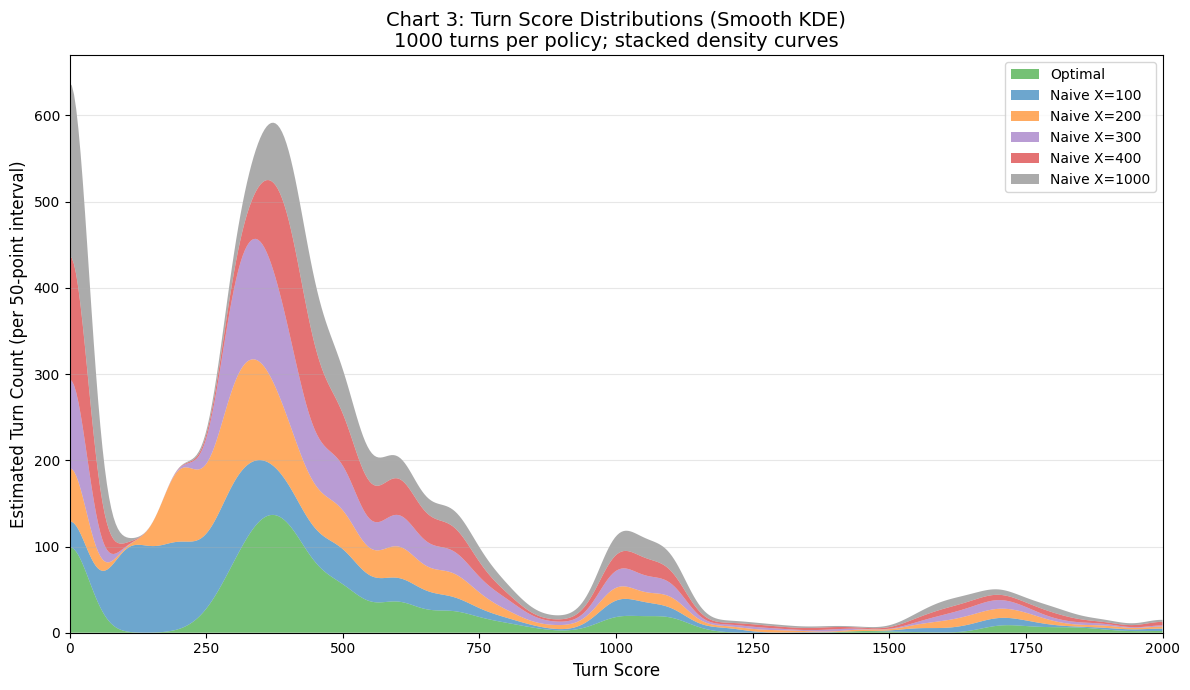


Chart 3 complete: Smooth stacked density curves for comparison with Chart 2 histogram


In [27]:
# === CHART 3: Turn Score Distributions (Smooth Curves) ===
# Alternative visualization: kernel density estimation (KDE) with stacked areas
# Same simulation data as Chart 2, but smoothed for comparison

from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

fig, ax = plt.subplots(figsize=(12, 7))

# Generate smooth x-axis for plotting
x_smooth = np.linspace(0, 2000, 500)

# Dictionary to store density functions for stacking
densities_by_policy = {}

print("\nComputing smooth density estimates for each policy...")

for name in order:
    scores = scores_by_policy[name]
    
    # Use KDE with significantly reduced bandwidth to preserve discrete structure
    # This makes high-bust-rate strategies' spike at 0 visible and honest
    kde = gaussian_kde(scores, bw_method='scott')
    kde.set_bandwidth(kde.factor * 0.25)  # ~50% reduction from default
    
    # Evaluate KDE on smooth grid
    density = kde(x_smooth)
    
    # Scale to represent turn counts per score interval:
    # density integrates to 1 over all scores
    # multiply by len(scores) to scale to total turn count
    # multiply by SCORE_STEP (bin width) to get approximate count per 50-point interval
    density_scaled = density * len(scores) * SCORE_STEP
    densities_by_policy[name] = density_scaled

# Stack the curves and fill areas
bottom = np.zeros_like(x_smooth)
for name in order:
    density_counts = densities_by_policy[name]
    ax.fill_between(
        x_smooth,
        bottom,
        bottom + density_counts,
        label=name,
        color=colors.get(name, "steelblue"),
        alpha=0.65,
        edgecolor='none',
    )
    bottom += density_counts

ax.set_xlabel("Turn Score", fontsize=12)
ax.set_ylabel("Estimated Turn Count (per 50-point interval)", fontsize=12)
ax.set_title(
    f"Chart 3: Turn Score Distributions (Smooth KDE)\n{num_turns} turns per policy; stacked density curves",
    fontsize=14,
)
ax.legend(loc="upper right", fontsize=10)
ax.grid(axis='y', alpha=0.3)

# X-axis cut off at 2000
ax.set_xlim(0, 2000)
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

print("\nChart 3 complete: Smooth stacked density curves for comparison with Chart 2 histogram")
